In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from skopt import BayesSearchCV
import shap
import pickle

In [254]:
products = pd.read_csv('Products Table.csv')
orders = pd.read_csv('Orders Table.csv')

# Feature Engineering

## Demand Indicators

### Monthly Sales Volume for Each Product

In [255]:
orders['Order Date'] = pd.to_datetime(orders['Order Date']) 

# number of sales for each product per month
monthly_sales_volume = orders.groupby(['ProductID', pd.Grouper(key='Order Date', freq='M')])['OrderID'].count().reset_index()
monthly_sales_volume.rename(columns={'OrderID': 'Monthly Sales Volume'}, inplace=True)

/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_83586/2658778723.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales_volume = orders.groupby(['ProductID', pd.Grouper(key='Order Date', freq='M')])['OrderID'].count().reset_index()


### Sales Trends

In [256]:
# 3-month rolling average of sales volume for each product
monthly_sales_volume['Sales Trend'] = monthly_sales_volume.groupby('ProductID')['Monthly Sales Volume'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
products = products.merge(monthly_sales_volume, on = 'ProductID', how = 'inner')

### Promotional Influence

In [257]:
# number of sales for each product when on promotion
promo_sales_volume = orders[orders['Promotional Period'] == 1].groupby('ProductID')['OrderID'].count().reset_index()
promo_sales_volume.rename(columns={'OrderID': 'Promo Sales Volume'}, inplace=True)

# number of sales for each product when not on promotion
non_promo_sales_volume = orders[orders['Promotional Period'] == 0].groupby('ProductID')['OrderID'].count().reset_index()
non_promo_sales_volume.rename(columns={'OrderID': 'Non Promo Sales Volume'}, inplace=True)

# merging
promo_influence = promo_sales_volume.merge(non_promo_sales_volume, on = 'ProductID', how = 'outer')
promo_influence = promo_influence.fillna(0) 

products = products.merge(promo_influence, on = 'ProductID', how = 'inner')

## Competitor Pricing

In [258]:
products['Competitor Price'] = round(products['Price'] * np.random.uniform(0.7, 1.3, size = len(products)), 2)
products['Price Comparison Index'] = products['Price']/products['Competitor Price'] # ratio of own price to competitor's price

## Inventory Levels

### Stock Levels

In [259]:
products['Stock Level'] = np.random.randint(0, 100, size = len(products))

### Restock Frequency

In [260]:
products['Restock Frequency'] = np.random.choice([10, 20, 30], len(products))

# EDA

In [261]:
df = products[['ProductID', 'Category', 'Monthly Sales Volume', 'Sales Trend', 'Promo Sales Volume', 'Non Promo Sales Volume', 'Price Comparison Index', 'Stock Level', 'Restock Frequency', 'Price']]

### Visualising Number of Records Per ProductID

Given the limited data available for each ProductID (with most products having only 5 to 10 records), building a reliable pricing model at the product level is impractical. Instead, we developed a dynamic pricing model based on product categories. This approach provides valuable insights into price ranges for each category, giving the business a more comprehensive view of pricing trends across different types of products.

          Category   count
0         Clothing  140476
1      Electronics    7140
2  Home Appliances    3304


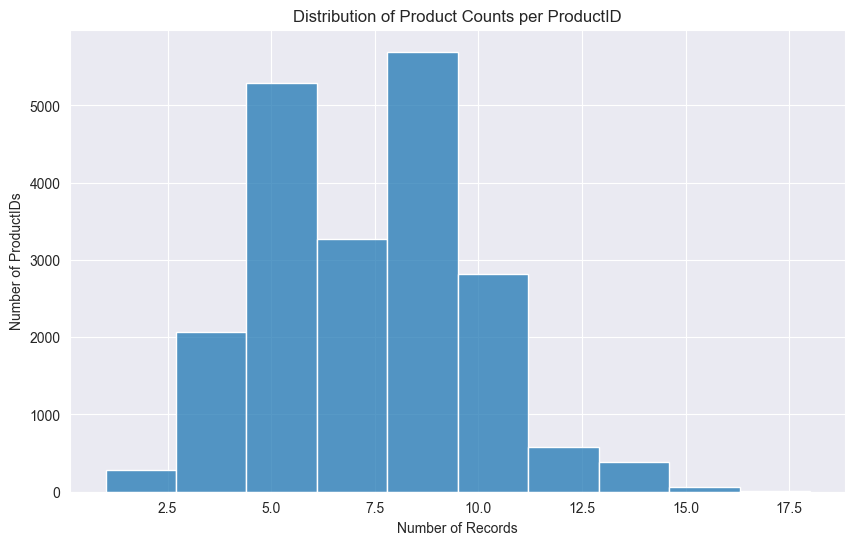

In [262]:
product_counts = products.groupby('ProductID').size().reset_index(name='count')
product_category_counts = products.groupby('Category').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.histplot(product_counts['count'], bins=10)
sns.set_style('darkgrid')
plt.xlabel("Number of Records")
plt.ylabel("Number of ProductIDs")
plt.title("Distribution of Product Counts per ProductID")

print(product_category_counts)

In [263]:
df.drop(columns = ['ProductID'], inplace = True)
print(f'Mising entries: \n{df.isna().sum()}')
print(f'Duplicated entries: {df.duplicated().sum()}')

df.drop_duplicates(inplace = True)

Mising entries: 
Category                  0
Monthly Sales Volume      0
Sales Trend               0
Promo Sales Volume        0
Non Promo Sales Volume    0
Price Comparison Index    0
Stock Level               0
Restock Frequency         0
Price                     0
dtype: int64
Duplicated entries: 18


/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_83586/2763913702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ['ProductID'], inplace = True)
/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_83586/2763913702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace = True)


## Monthly Sales Volume Across Categories

There are only 4 unique values of monthly sales volume (1, 2, 3, 4). We plot a side by side barchart to see how monthly sales volume is distributed amongst the categories. 

(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

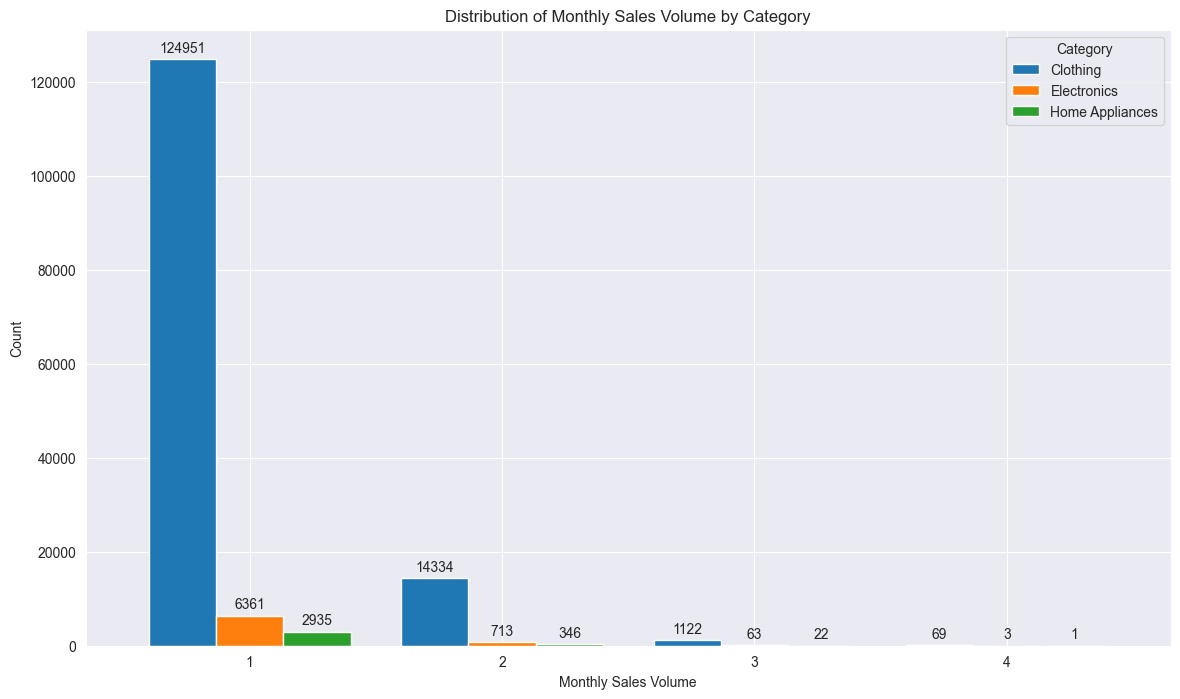

In [264]:
# group by 'Category' and 'Monthly Sales Volume' then count occurrences
volume_counts = products.groupby(['Category', 'Monthly Sales Volume']).size().reset_index(name='count')

# pivot data for side-by-side plotting
volume_pivot = volume_counts.pivot(index='Monthly Sales Volume', columns='Category', values='count').fillna(0)
ax = volume_pivot.plot(kind='bar', figsize=(14, 8), width=0.8)

# add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

plt.xlabel("Monthly Sales Volume")
plt.ylabel("Count")
plt.title("Distribution of Monthly Sales Volume by Category")
plt.legend(title="Category")
plt.xticks(rotation = 0)

## Sales Trend

There are only 4 unique values of monthly sales volume (1, 2, 3, 4). We plot a side by side barchart to see how monthly sales volume is distributed amongst the categories. 

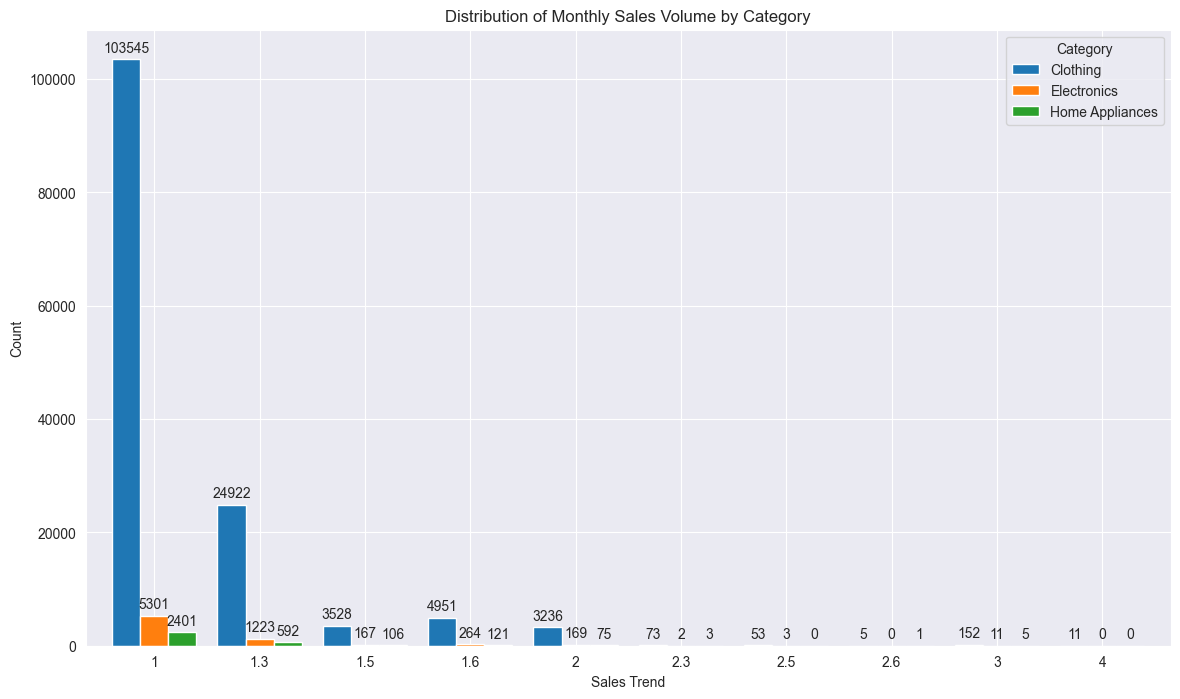

In [265]:
# group by 'Category' and 'Sales Trend' then count occurrences
volume_counts = products.groupby(['Category', 'Sales Trend']).size().reset_index(name='count')

# pivot data for side-by-side plotting
volume_pivot = volume_counts.pivot(index='Sales Trend', columns='Category', values='count').fillna(0)
ax = volume_pivot.plot(kind='bar', figsize=(14, 8), width=0.8)

# add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
xticklabels = [1, 1.3, 1.5, 1.6, 2, 2.3, 2.5, 2.6, 3, 4]

ax.set_xticks(x_ticks)
ax.set_xticklabels(xticklabels)
plt.xlabel("Sales Trend")
plt.ylabel("Count")
plt.title("Distribution of Monthly Sales Volume by Category")
plt.legend(title="Category")
plt.xticks(rotation = 0)
plt.show()

## Promo Sales Volume

The distributions for promo sales volume is quite similar across categories.

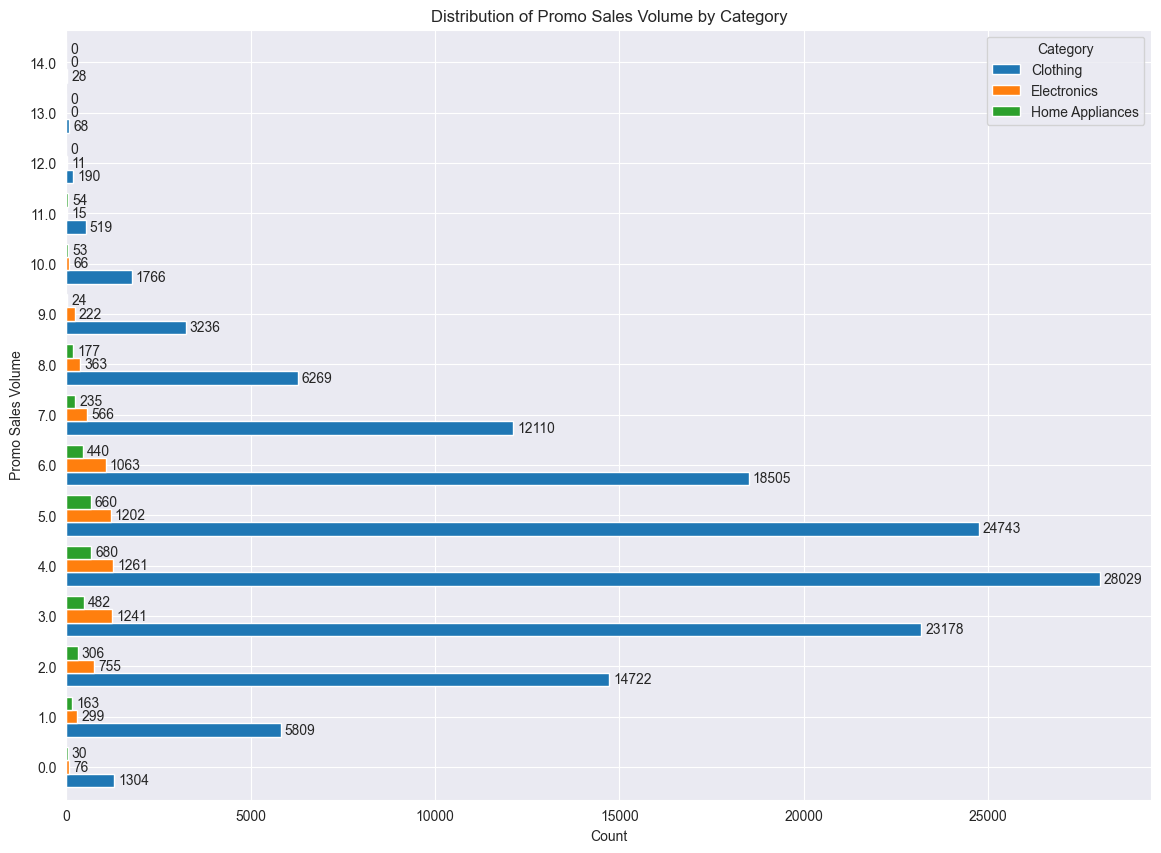

In [266]:
# group by 'Category' and 'Monthly Sales Volume' then count occurrences
volume_counts = products.groupby(['Category', 'Promo Sales Volume']).size().reset_index(name='count')

# pivot data for side-by-side plotting
volume_pivot = volume_counts.pivot(index='Promo Sales Volume', columns='Category', values='count').fillna(0)
ax = volume_pivot.plot(kind='barh', figsize=(14, 10), width=0.8)

# add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize = 10)

plt.ylabel("Promo Sales Volume")
plt.xlabel("Count")
plt.title("Distribution of Promo Sales Volume by Category")
plt.legend(title="Category")
plt.xticks(rotation = 0)
plt.show()

## Non Promo Sales Volume

The distributions for non promo sales volume also seems to be quite similarly distributed across categories. 

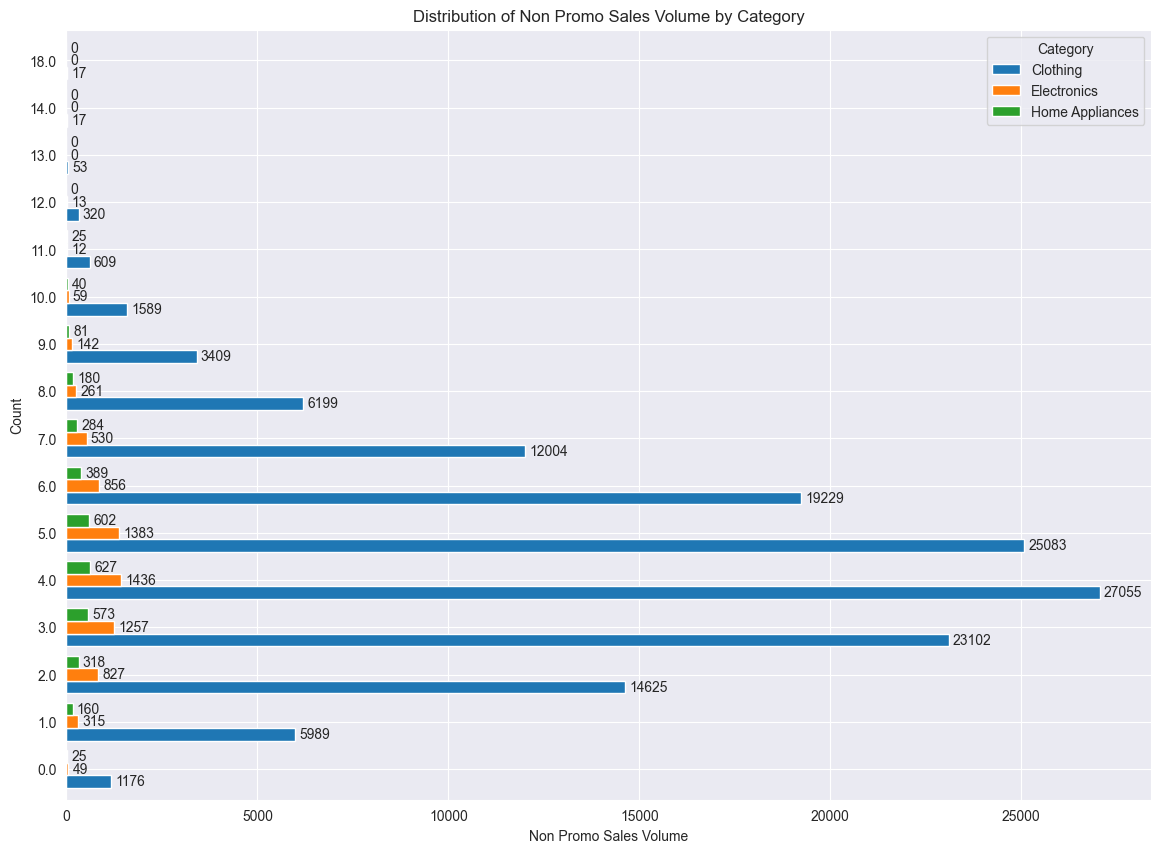

In [267]:
# group by 'Category' and 'Monthly Sales Volume' then count occurrences
volume_counts = products.groupby(['Category', 'Non Promo Sales Volume']).size().reset_index(name='count')

# pivot data for side-by-side plotting
volume_pivot = volume_counts.pivot(index='Non Promo Sales Volume', columns='Category', values='count').fillna(0)
ax = volume_pivot.plot(kind='barh', figsize=(14, 10), width=0.8)

# add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize = 10)

plt.xlabel("Non Promo Sales Volume")
plt.ylabel("Count")
plt.title("Distribution of Non Promo Sales Volume by Category")
plt.legend(title="Category")
plt.xticks(rotation = 0)
plt.show()

## Price Comparison Index

The price comparison index is has a similar (almost uniform distribution) across categories.  

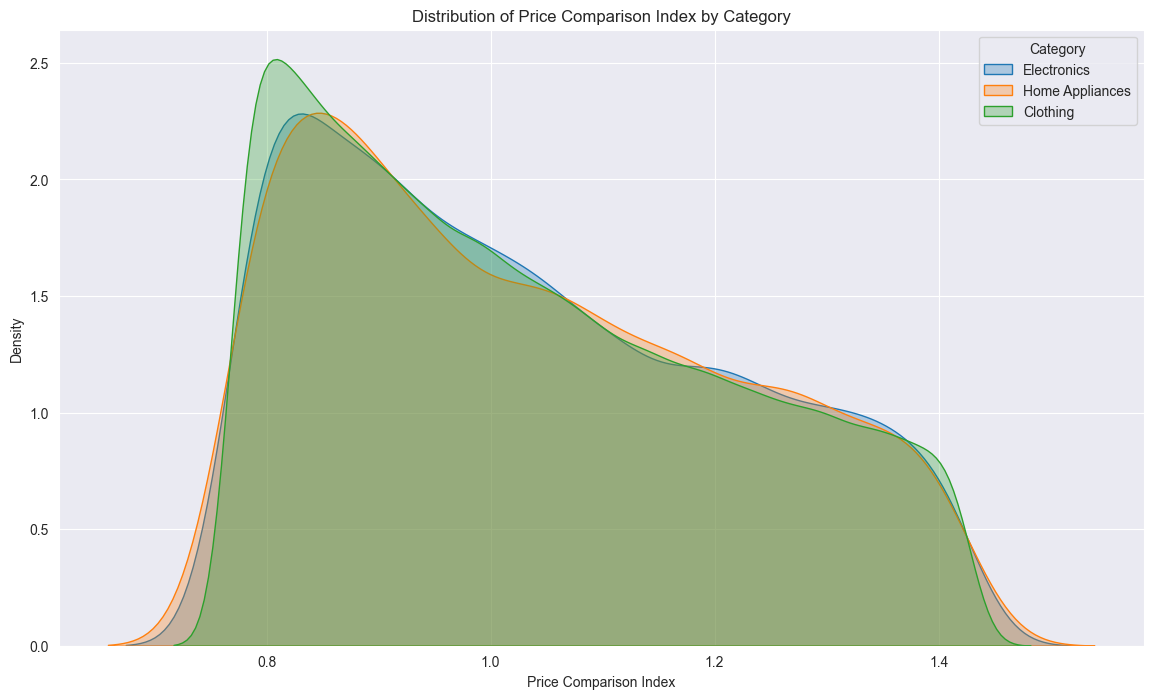

In [268]:
plt.figure(figsize=(14, 8))

# density plot for each category in one graph
for category in df['Category'].unique():
    sns.kdeplot(
        data=df[df['Category'] == category],
        x='Price Comparison Index',
        label=category,
        fill=True,
        alpha=0.3,
    )

plt.xlabel("Price Comparison Index")
plt.ylabel("Density")
plt.title("Distribution of Price Comparison Index by Category")
plt.legend(title="Category")

## Stock Level

Stock levels are also similarly uniformly distributed across categories. 

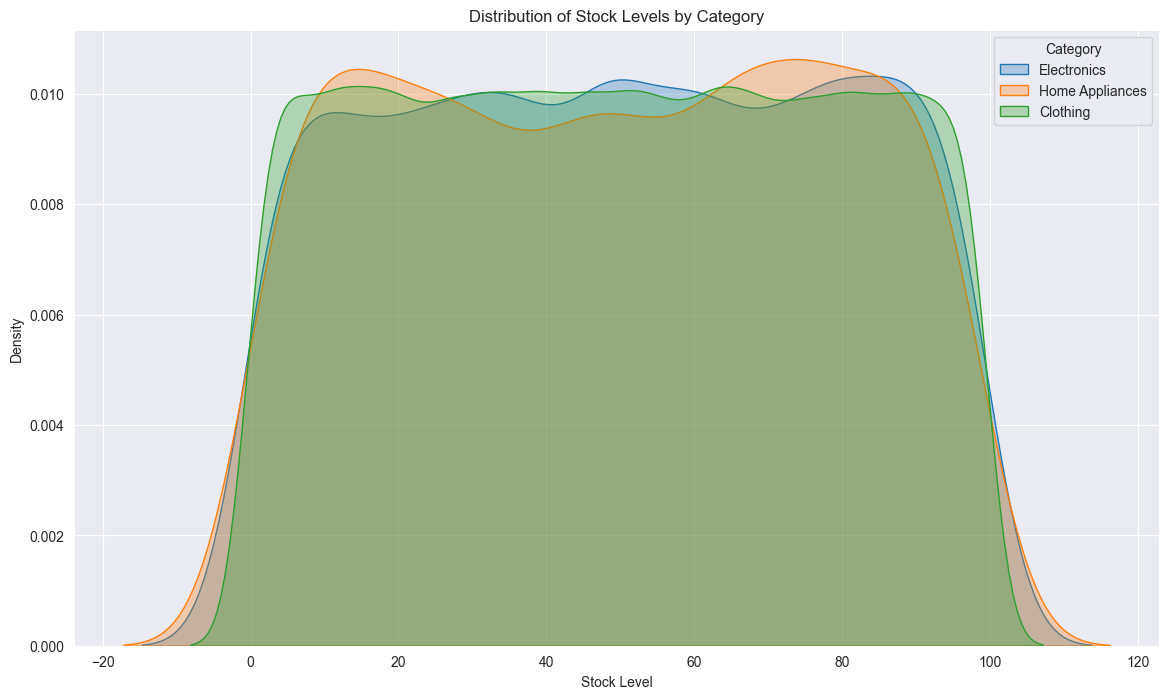

In [269]:
plt.figure(figsize=(14, 8))

# density plot for each category in one graph
for category in df['Category'].unique():
    sns.kdeplot(
        data=df[df['Category'] == category],
        x='Stock Level',
        label=category,
        fill=True,
        alpha=0.3,
    )

plt.xlabel("Stock Level")
plt.ylabel("Density")
plt.title("Distribution of Stock Levels by Category")
plt.legend(title="Category")

## Restock Frequency

(array([0, 1, 2]), [Text(0, 0, '10'), Text(1, 0, '20'), Text(2, 0, '30')])

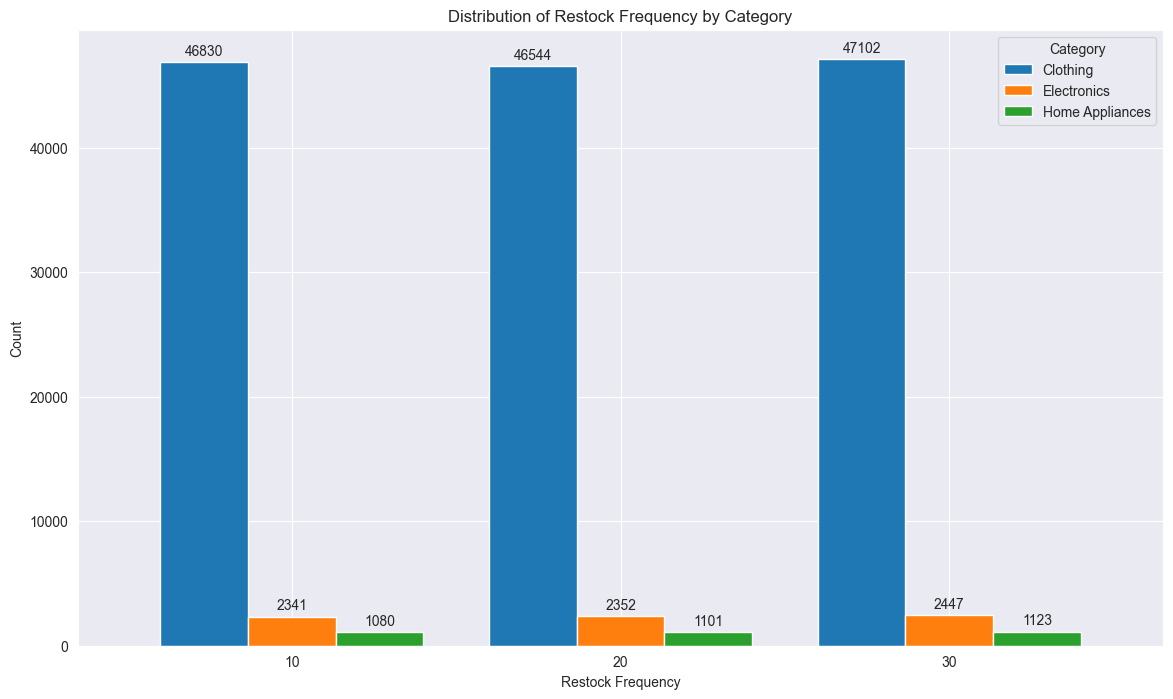

In [270]:
# group by 'Category' and 'Restock Frequency' and count occurrences
volume_counts = products.groupby(['Category', 'Restock Frequency']).size().reset_index(name='count')

# pivot data for side-by-side plotting
volume_pivot = volume_counts.pivot(index='Restock Frequency', columns='Category', values='count').fillna(0)
ax = volume_pivot.plot(kind='bar', figsize=(14, 8), width=0.8)

# add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

plt.xlabel("Restock Frequency")
plt.ylabel("Count")
plt.title("Distribution of Restock Frequency by Category")
plt.legend(title="Category")
plt.xticks(rotation = 0)

## Price

The initial plot for price is very right-skewed because of a few products with very high prices. To address, we remove products with prices that are in the bottom and top 5 percentiles. 

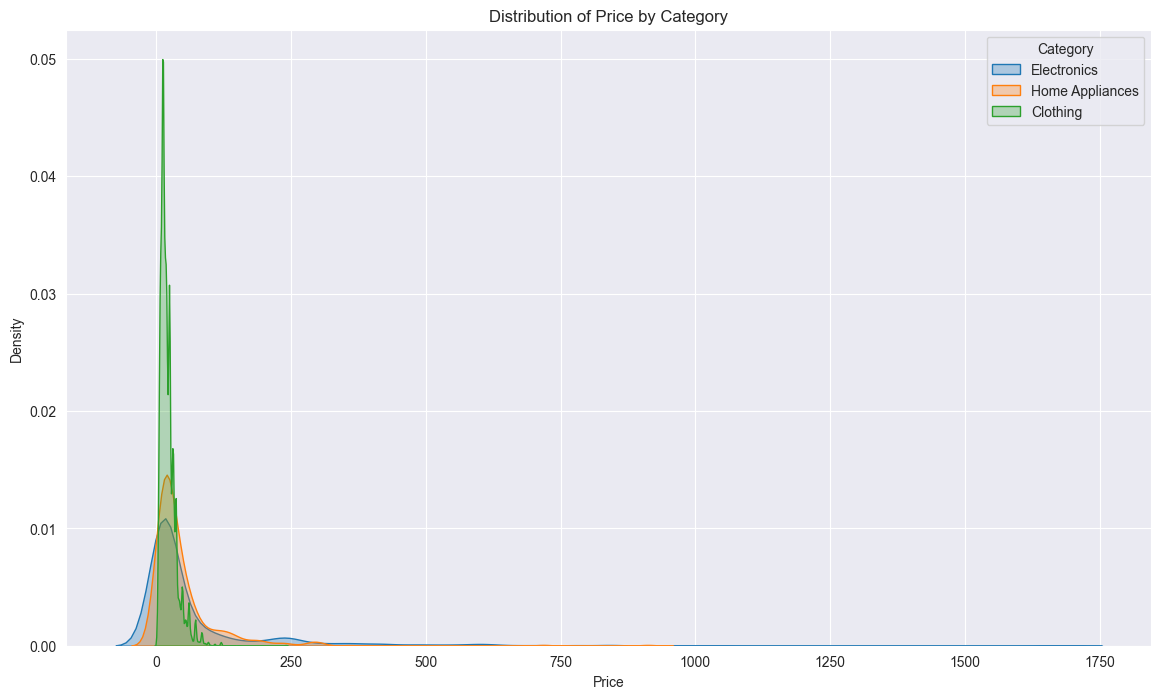

In [271]:
plt.figure(figsize=(14, 8))

# density plot for each category in one graph
for category in df['Category'].unique():
    sns.kdeplot(
        data=df[df['Category'] == category],
        x='Price',
        label=category,
        fill=True,
        alpha=0.3,
    )


plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Distribution of Price by Category")
plt.legend(title="Category")
plt.show()

### Transformations of Price

The distributions still seems slightly right-skewed, so we apply logarithm transformation to make it less skewed.

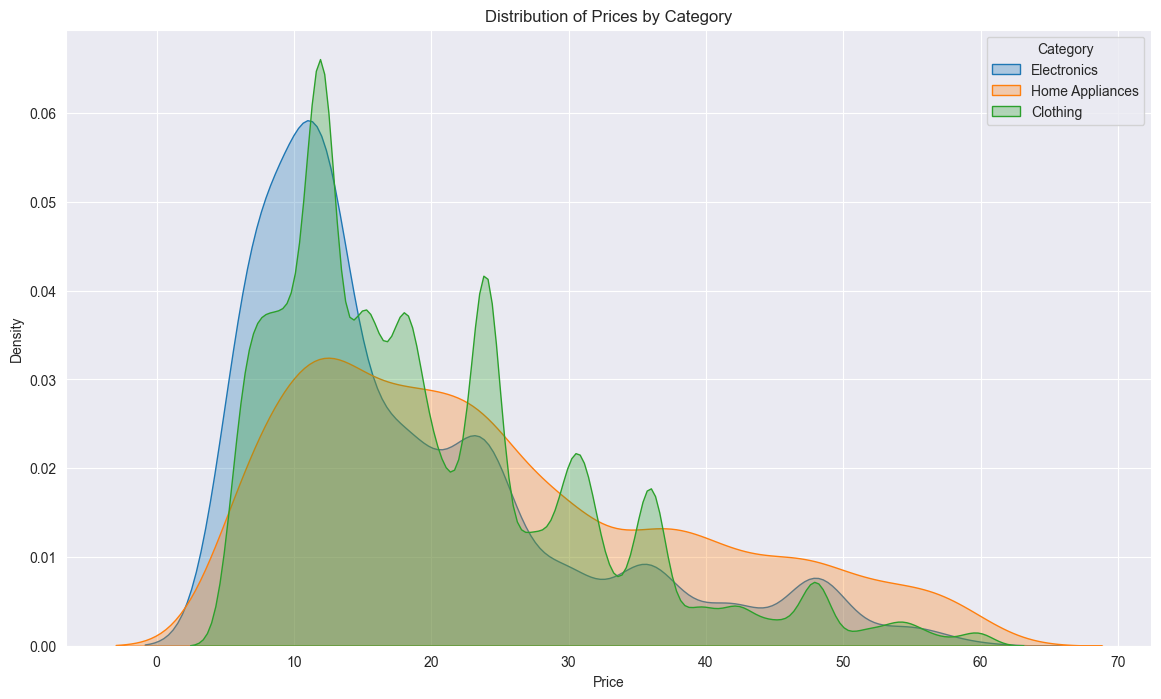

In [272]:
# removing top and bottom 5 percentiles
df = df[(df['Price'] >= df['Price'].quantile(0.05)) & (df['Price'] <= df['Price'].quantile(0.95))]

plt.figure(figsize=(14, 8))

# density plot for each category in one graph
for category in df['Category'].unique():
    sns.kdeplot(
        data=df[df['Category'] == category],
        x='Price',
        label=category,
        fill=True,
        alpha=0.3,
    )

plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Distribution of Prices by Category")
plt.legend(title="Category")
plt.show()

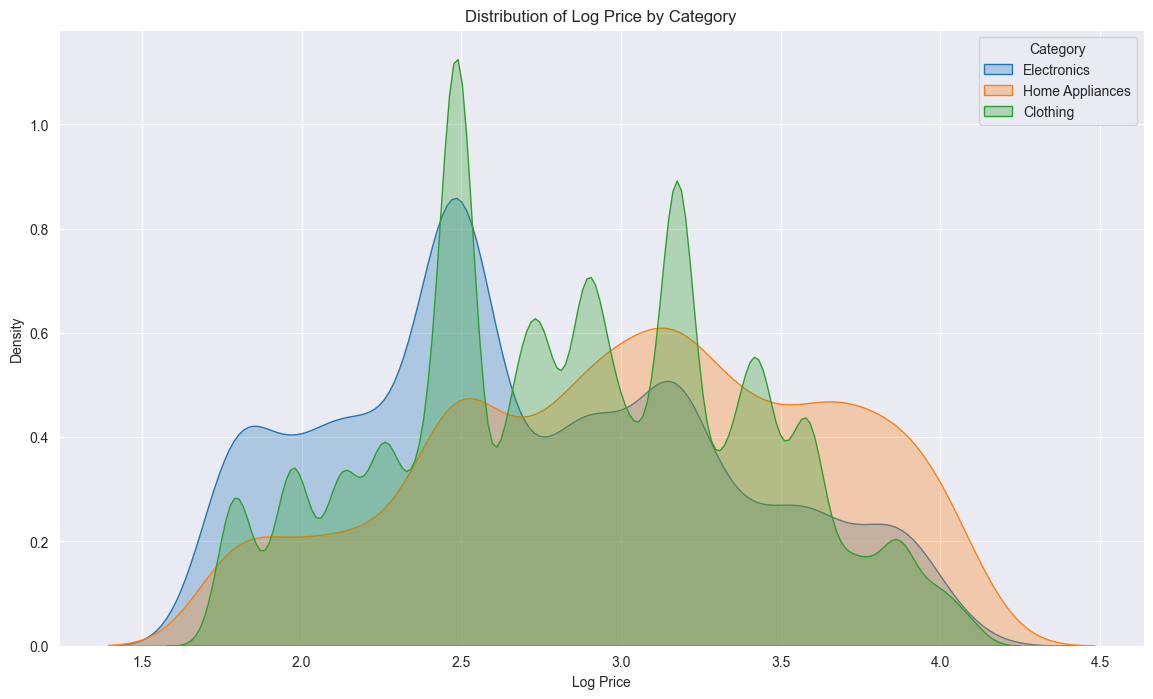

In [273]:
df['log_price'] = np.log(df['Price'])

plt.figure(figsize=(14, 8))

# density plot for each category in one graph
for category in df['Category'].unique():
    sns.kdeplot(
        data=df[df['Category'] == category],
        x='log_price',
        label=category,
        fill=True,
        alpha=0.3,
    )

plt.xlabel("Log Price")
plt.ylabel("Density")
plt.title("Distribution of Log Price by Category")
plt.legend(title="Category")
plt.show()

# Dynamic Pricing Model

### Train Test Split

In [274]:
X = df.drop(columns = ['Price', 'log_price'])
X = pd.get_dummies(X, columns=['Category'], drop_first=True)
y = df[['log_price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# converting boolean to binary for SHAP later on
X_train['Category_Electronics'] = X_train['Category_Electronics'].astype(int)
X_train['Category_Home Appliances'] = X_train['Category_Home Appliances'].astype(int)
X_test['Category_Electronics'] = X_test['Category_Electronics'].astype(int)
X_test['Category_Home Appliances'] = X_test['Category_Home Appliances'].astype(int)

### Choosing Best Models

In [275]:
models = {
    'XGBRegressor': XGBRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
}

param_grids = {
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9]
    },
    'LinearRegression': {}, 
}

rmse_scores = {}

for model_name, model in models.items():
    if param_grids.get(model_name):
            BayesSearch = BayesSearchCV(
            estimator=model,
            search_spaces=param_grids[model_name],
            n_iter=20,
            scoring='neg_root_mean_squared_error',
            cv=4,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
            # fitting BayesSearch
            BayesSearch.fit(X_train, y_train)
            best_model = BayesSearch.best_estimator_
            print(f"Best parameters for {model_name}: {BayesSearch.best_params_}")
    else:
        # for linear regression (no parameters to tune)
        best_model = model
        best_model.fit(X_train, y_train)
    
    # making predictions based on chosen model
    y_pred = best_model.predict(X_test)
    rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred)) # converting log prices back to original prices for calculation of rmse
    rmse_scores[model_name] = rmse
    print(f'{model_name} RMSE: {rmse}')

best_model_name = min(rmse_scores, key=rmse_scores.get)
print(f'\nBest Model: {best_model_name} with RMSE of {rmse_scores[best_model_name]}')

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Best parameters for RandomForestRegressor: OrderedDict([('max_depth', 15), ('min_samples_leaf', 1), ('min_samples_split', 5), ('n_estimators', 300)])
RandomForestRegressor RMSE: 11.581966809424474
Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Best parameters for GradientBoostingRegressor: OrderedDict([('learning_rate', 0.1), ('max_depth', 5), ('n_estimators', 300), ('subsample', 0.8)])
GradientBoostingRegressor RMSE: 11.476912902535169
LinearRegression RMSE: 11.656847024597688

Best Model: GradientBoostingRegressor with RMSE of 11.476912902535169


### Best Model

In [276]:
model = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8, random_state=42)
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(max_depth=5, n_estimators=300, random_state=42,
                          subsample=0.8)

### Feature Importance

Text(0.5, 1.0, 'Feature Importance from GradientBoostingRegressor')

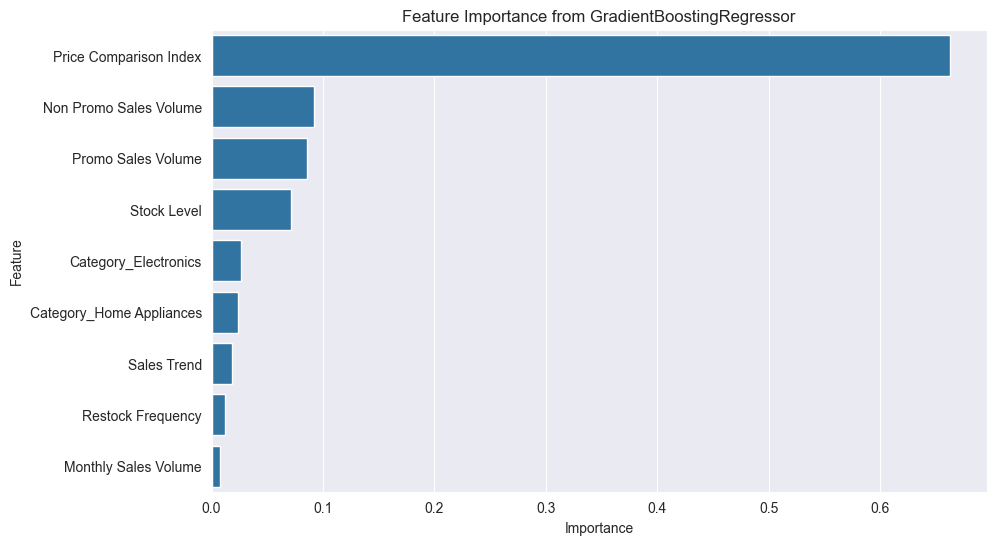

In [277]:
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance from GradientBoostingRegressor")

### SHAP

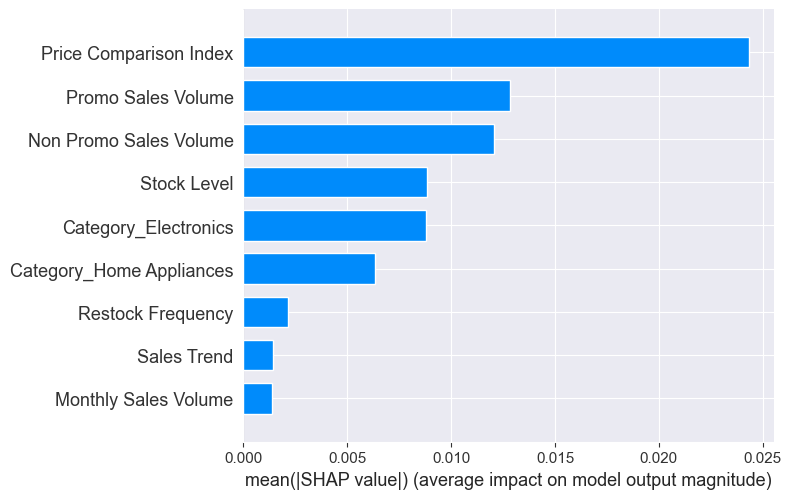

In [278]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

sns.set_style('darkgrid')
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Saving Trained Model

In [279]:
with open('PricingModel.pkl', 'wb') as file:
    pickle.dump(model, file)